# Importe y exploración

## Librerias

In [1]:
import numpy as np 
import pandas as pd
import os
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
#from sklearn.metrics import plot_confusion_matrix
import seaborn as sn
import IPython
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.layers import Dense, Input, Conv1D, Lambda, Flatten, Reshape, BatchNormalization, Add, Dropout, Conv2D, LayerNormalization
from tensorflow.python.keras.models import Model, load_model, Sequential
from tensorflow.python.keras.layers.merge import Concatenate, Dot, Multiply
import time
#import wandb
#from wandb.keras import WandbCallback
from sklearn.datasets import make_blobs
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from random import sample, randint
import itertools
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import plot_importance
import matplotlib.pyplot as plt
ticks = int(time.time())

tf.sysconfig.get_link_flags()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

## Cargar datos limpios

In [2]:
from google.colab import files
uploaded = files.upload()

Saving clean_data.csv to clean_data.csv


## Funciones utiles

In [3]:
def csv2dict(my_data, listar = False):

	#my_data = pd.read_csv(csv,sep=',')
	print(my_data.head())

	armaDict = { i : my_data.columns[i] for i in range(0, len(my_data.columns) ) }

	if listar == True:

		[print(key, value) for key, value in armaDict.items()]

	return armaDict

def mvn(feature):
	min_max_scaler = preprocessing.StandardScaler()
	x_scaled = min_max_scaler.fit_transform(feature)
	df = pd.DataFrame(x_scaled)
	return df

## Se carga dataset y se trasforma a un problema de clasificación

In [5]:
csv = "clean_data.csv"

my_data = pd.read_csv(csv,sep=',')
print(my_data.head())


#hacemos el porcentaje de logros por rangos
# insatisfactorio [0]
# Basico bajo [1]
# Basico regular [2]
# Competente [3]
# Destacado [4]
for i in range(len(my_data['PORCENTAJE DE LOGRO'])):
  x = my_data['PORCENTAJE DE LOGRO'][i]
  if x < 0.40:
    my_data['PORCENTAJE DE LOGRO'][i] = 0
  if x < 0.60 and x >= 0.40:
    my_data['PORCENTAJE DE LOGRO'][i] = 1
  if x < 0.70 and x >= 0.60:
    my_data['PORCENTAJE DE LOGRO'][i] = 2
  if x < 0.90 and x >= 0.70:
    my_data['PORCENTAJE DE LOGRO'][i] = 3
  if x >= 0.90:
    my_data['PORCENTAJE DE LOGRO'][i] = 4

print(my_data['PORCENTAJE DE LOGRO'])

   Unnamed: 0  PORCENTAJE DE LOGRO  ...  PSU LENGUAJE  VIA DE INGRESO
0           1             0.312500  ...         612.0               6
1           2             0.312500  ...         684.0               6
2           3             0.333333  ...         729.0               2
3           5             0.375000  ...         660.0               6
4           7             0.437500  ...         626.0               2

[5 rows x 6 columns]
0       0.0
1       0.0
2       0.0
3       0.0
4       1.0
       ... 
2215    3.0
2216    3.0
2217    3.0
2218    4.0
2219    4.0
Name: PORCENTAJE DE LOGRO, Length: 2220, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarn

## Conteo de clases

0: 18 , 1: 343 , 2: 741 , 3: 1094 , 4: 24


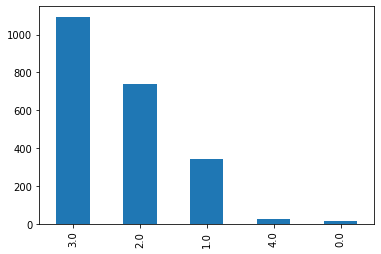

In [6]:
# Gender distribution
my_data['PORCENTAJE DE LOGRO'].value_counts().plot(kind='bar')

def count_classes(df):
  return len(my_data[my_data['PORCENTAJE DE LOGRO'] == 0]), len(my_data[my_data['PORCENTAJE DE LOGRO'] == 1]), len(my_data[my_data['PORCENTAJE DE LOGRO'] == 2]), len(my_data[my_data['PORCENTAJE DE LOGRO'] == 3]), len(my_data[my_data['PORCENTAJE DE LOGRO'] == 4])

print('0:', count_classes(my_data)[0], ", 1:", count_classes(my_data)[1], ", 2:", count_classes(my_data)[2], ", 3:", count_classes(my_data)[3], ", 4:", count_classes(my_data)[4])

Las clases estan inbalanceadas

In [7]:
armaDict = csv2dict(my_data, listar = True)

   Unnamed: 0  PORCENTAJE DE LOGRO  ...  PSU LENGUAJE  VIA DE INGRESO
0           1                  0.0  ...         612.0               6
1           2                  0.0  ...         684.0               6
2           3                  0.0  ...         729.0               2
3           5                  0.0  ...         660.0               6
4           7                  1.0  ...         626.0               2

[5 rows x 6 columns]
0 Unnamed: 0
1 PORCENTAJE DE LOGRO
2 TIPO DE ESTABLECIMIENTO
3 NEM
4 PSU LENGUAJE
5 VIA DE INGRESO


# Modelo

# Feature Importance

In [9]:
KeysList=[2,3,4,5] #features para entrenar

analisis_features= pd.DataFrame(columns=['keysFeatures','testAcc', 'RMSE' ])
importacia_features= pd.DataFrame(columns=['keysFeatures','importance','testAcc'])

Features elegidos:  (2, 3)
      testAcc3  MeanSquaredError3
mean  0.468018           1.009910
std   0.499089           1.480196
 
Acc: 46.000
 
RMSE: 1.005
 
['TIPO DE ESTABLECIMIENTO', 'NEM']
 
keysFeatures    object
importance      object
testAcc         object
dtype: object
Features elegidos:  (2, 4)
      testAcc3  MeanSquaredError3
mean  0.477027           0.906306
std   0.499584           1.321045
 
Acc: 47.000
 
RMSE: 0.952
 
['TIPO DE ESTABLECIMIENTO', 'PSU LENGUAJE']
 
keysFeatures    object
importance      object
testAcc         object
dtype: object
Features elegidos:  (2, 5)
      testAcc3  MeanSquaredError3
mean  0.502703           0.948649
std   0.500105           1.439190
 
Acc: 50.000
 
RMSE: 0.974
 
['TIPO DE ESTABLECIMIENTO', 'VIA DE INGRESO']
 
keysFeatures    object
importance      object
testAcc         object
dtype: object
Features elegidos:  (3, 4)
      testAcc3  MeanSquaredError3
mean  0.486937           0.891441
std   0.499942           1.351786
 
Acc: 48.000


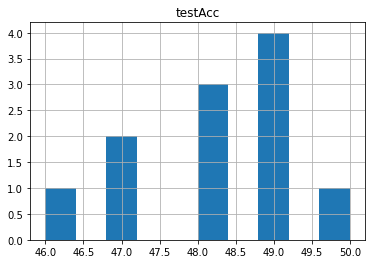

In [10]:
ind=0

for L in range(2,len(KeysList)+1):

  for Keys in itertools.combinations(KeysList,L):
    ind=ind+1
    print("Features elegidos: ",Keys)

    X3 = my_data[[armaDict.get(key) for key in Keys]].values
    for i in range(len(Keys)):
      X3[:,i]=np.squeeze(X3[:,i].reshape(-1, 1)) #

    y=np.ravel(my_data[['PORCENTAJE DE LOGRO']])
    OutputDataframe = pd.DataFrame(columns=['testAcc3', 'MeanSquaredError3' ])
    index=0
    confMatrix = np.zeros((4,4))
    confMatrixDummy = np.zeros((4,4))
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred3, featImp = list(), list(), list()

    for train_ix, test_ix in cv.split(X3):
      np.random.shuffle(train_ix)
      X_trainset_co, X_testset_co = X3[train_ix, :], X3[test_ix, :]
      y_train, y_test = y[train_ix], y[test_ix]
      model3 = XGBClassifier()
      history3 = model3.fit(X_trainset_co, y_train)
      prediction3 = model3.predict(X_testset_co)
      y_true.append(y_test)
      y_pred3.append(prediction3)
      #print(model3.feature_importances_)
      featImp.append(model3.feature_importances_)
      MSEtest3 = metrics.mean_squared_error( y_test, prediction3)
      testAcc3 = accuracy_score(y_test, prediction3)
      #testAcc3 = metrics.clf.score(prediction3, y_test) #este acurracy porque estamos prediciendo numeros
      OutputDataframe.loc[index] = [testAcc3, MSEtest3]
      index=index+1

    OutputSummary = OutputDataframe.agg(['mean', 'std'])
    print(OutputSummary)
    RMSE3 = np.sqrt(OutputSummary['MeanSquaredError3']['mean'])
    Acc3 = int(OutputSummary['testAcc3']['mean']*100)
    OutputSummary = OutputSummary.transpose()
    print(' ')
    print('Acc: %.3f' % Acc3)
    print(' ')
    print('RMSE: %.3f' % RMSE3)
    print(' ')
    print([armaDict.get(key) for key in Keys])
    print(' ')
    analisis_features.loc[ind]=[str(Keys),Acc3,RMSE3]
    importacia_features.loc[ind]=[str(Keys), np.mean(featImp,axis=0), Acc3]
    print(importacia_features.dtypes)

importacia_features['testAcc'] = importacia_features['testAcc'].astype('int32')
importacia_features.hist(column='testAcc')
plt.show()

In [12]:
print(importacia_features)

    keysFeatures                                       importance  testAcc
1         (2, 3)                          [0.47646898, 0.5235311]       46
2         (2, 4)                           [0.3294104, 0.6705887]       47
3         (2, 5)                           [0.266749, 0.73324764]       50
4         (3, 4)                         [0.33048084, 0.66951966]       48
5         (3, 5)                           [0.3733704, 0.6266324]       48
6         (4, 5)                         [0.57517314, 0.42482677]       49
7      (2, 3, 4)                 [0.2503882, 0.2483394, 0.501273]       48
8      (2, 3, 5)             [0.23541816, 0.28511715, 0.47946557]       47
9      (2, 4, 5)             [0.21204107, 0.45227978, 0.33567855]       49
10     (3, 4, 5)               [0.21602166, 0.44679013, 0.337188]       49
11  (2, 3, 4, 5)  [0.17899199, 0.18125056, 0.36842754, 0.2713301]       49


Mejor combinación dio los features 2 y 5.

# Entrenamiento L1O

Se han truncado las últimas 5000 líneas del flujo de salida.
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
[3.] [1.]
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
[3.] [1.]
XGBClassifier(base_score=0.5, booster='gbtree', co

(4.0, 0.0)

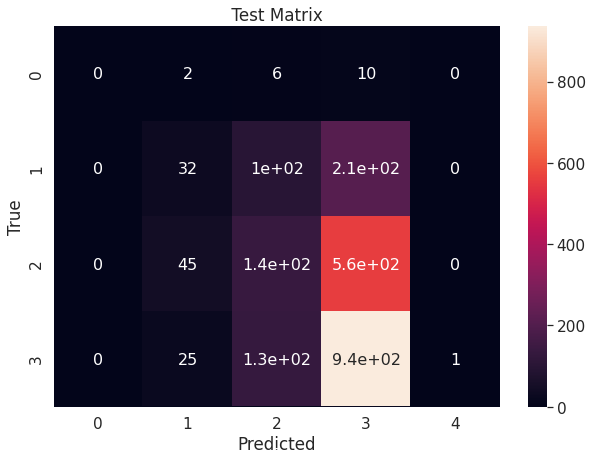

In [19]:
# featureString = str(ticks)
# epocsa = 50
# batchSize = 1
#Parametros que pueden servir:
X=my_data[[armaDict.get(key) for key in KeysList]].values
y=np.ravel(my_data[['PORCENTAJE DE LOGRO']])
confMatrix = np.zeros((5,5))
confMatrixDummy = np.zeros((5,5))
OutputDataframe = pd.DataFrame(columns=['testAcc', 'MeanSquaredError' ])
# enumerate splits
index = 0
y_true, y_pred = list(), list()
cv = LeaveOneOut()
for train_ix, test_ix in cv.split(X):
  np.random.shuffle(train_ix)
  X_trainset, X_testset = X[train_ix, :], X[test_ix, :]
  y_train, y_test = y[train_ix], y[test_ix]

  model = XGBClassifier()
  history = model.fit(X_trainset, y_train)
  print(history)
  prediction = model.predict(X_testset)
  print(prediction, y_test)

  y_true.append(y_test)
  y_pred.append(prediction)

  MSEtest = metrics.mean_squared_error(y_test, prediction)
  testAcc = accuracy_score(y_test, prediction)

  tf.keras.backend.clear_session()

  OutputDataframe.loc[index] = [testAcc, MSEtest]
  index=index+1



#IPython.embed()
#model.save(os.path.join(wandb.run.dir, "model.h5"))


OutputSummary = OutputDataframe.agg(['mean', 'std'])
print(OutputSummary)
print(OutputSummary['MeanSquaredError']['mean'])
RMSE = np.sqrt(OutputSummary['MeanSquaredError']['mean'])
OutputSummary = OutputSummary.transpose()
acc = accuracy_score(y_true, y_pred)

print('RMSE: %.3f' % RMSE)
print('Accuracy: %.3f' % acc)

confMatrix = confusion_matrix(y_true, y_pred)
print(confMatrix)
print(' ')
print(' ')
print([armaDict.get(key) for key in KeysList])
print(' ')
print(' ')
print(' ')

sn.set(color_codes=True)
testMatrix = pd.DataFrame(confMatrix, range(5), range(5))

sn.set(font_scale=1.4) # for label size
plt.figure(figsize=(10,7))
sn.heatmap(testMatrix, annot=True, annot_kws={"size": 16}) # font size
plt.title(' Test Matrix ')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.ylim((4,0))
#plt.savefig(os.path.join(wandb.run.dir, ' DNN  Test'+featureString+ ' Matrix.png'))

No da muy buenos resultados la matriz de confución

## Entrenamiento con split de datos 70% train 30% test

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
RMSE: 0.913
Accuracy: 0.502


(4.0, 0.0)

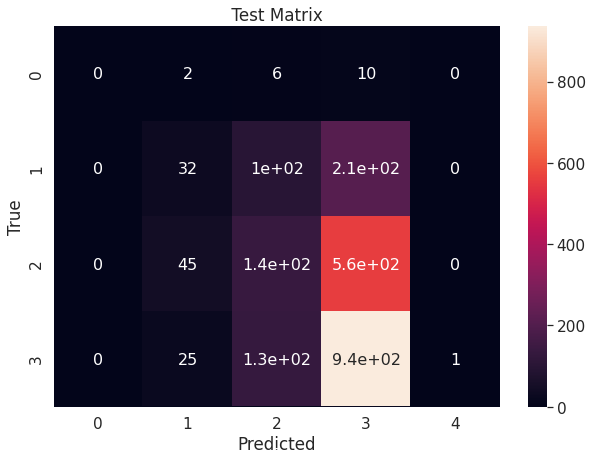

In [14]:
featureString = str(ticks)
epocsa = 50
batchSize = 1
#Parametros que pueden servir:
X=my_data[[armaDict.get(key) for key in KeysList]].values
y=np.ravel(my_data[['PORCENTAJE DE LOGRO']])
confMatrix = np.zeros((5,5))
confMatrixDummy = np.zeros((5,5))
outputDataframe = pd.DataFrame(columns=['testAcc', 'MeanSquaredError' ])
# enumerate splits
index = 0
y_true, y_pred = list(), list()
# split data
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)

model = XGBClassifier()
history = model.fit(x_train, y_train)
print(history)
prediction = model.predict(x_test)
#print(prediction, y_test)

MSEtest = metrics.mean_squared_error(prediction, y_test)

# y_true.append(y_test)
# y_pred.append(prediction)

MSEtest = metrics.mean_squared_error(y_test, prediction)

testAcc = accuracy_score(y_test, prediction)

# tf.keras.backend.clear_session()

# OutputDataframe.loc[index] = [testAcc, MSEtest]
# index=index+1



#IPython.embed()
#model.save(os.path.join(wandb.run.dir, "model.h5"))


# OutputSummary = outputDataframe.agg(['mean', 'std'])
# print(OutputSummary)
# print(OutputSummary['MeanSquaredError']['mean'])
RMSE = np.sqrt(MSEtest)
# OutputSummary = OutputSummary.transpose()
#acc = accuracy_score(y_true, y_pred)

print('RMSE: %.3f' % RMSE)
print('Accuracy: %.3f' % testAcc)

confMatrix = confusion_matrix(y_test, prediction)
# print(confMatrix)
# print(' ')
# print(' ')
# print([armaDict.get(key) for key in KeysList])
# print(' ')
# print(' ')
# print(' ')

# sn.set(color_codes=True)
# testMatrix = pd.DataFrame(confMatrix, range(5), range(5))

sn.set(font_scale=1.4) # for label size
plt.figure(figsize=(10,7))
sn.heatmap(testMatrix, annot=True, annot_kws={"size": 16}) # font size
plt.title(' Test Matrix ')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.ylim((4,0))
#plt.savefig(os.path.join(wandb.run.dir, ' DNN  Test'+featureString+ ' Matrix.png'))

In [15]:
model.feature_importances_

array([0.19266416, 0.19067919, 0.3666454 , 0.2500113 ], dtype=float32)

## Entramiento con oversampling de clases

Before oversampling:  Counter({3.0: 752, 2.0: 533, 1.0: 238, 4.0: 17, 0.0: 14})
After oversampling:  Counter({1.0: 752, 3.0: 752, 2.0: 752, 0.0: 752, 4.0: 752})
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
RMSE: 1.034
Accuracy: 0.446


(4.0, 0.0)

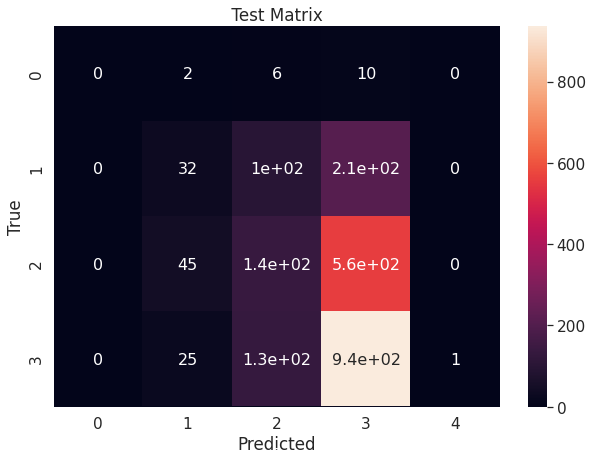

In [17]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


X=my_data[[armaDict.get(key) for key in KeysList]].values
y=np.ravel(my_data[['PORCENTAJE DE LOGRO']])
confMatrix = np.zeros((5,5))
confMatrixDummy = np.zeros((5,5))
outputDataframe = pd.DataFrame(columns=['testAcc', 'MeanSquaredError' ])
# enumerate splits
index = 0
y_true, y_pred = list(), list()
# split data
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)
print("Before oversampling: ",Counter(y_train))

SMOTE = SMOTE()

x_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(x_train, y_train)
print("After oversampling: ",Counter(y_train_SMOTE))

model = XGBClassifier()
history = model.fit(x_train_SMOTE, y_train_SMOTE)
print(history)
prediction = model.predict(x_test)
#print(prediction, y_test)

MSEtest = metrics.mean_squared_error(prediction, y_test)

# y_true.append(y_test)
# y_pred.append(prediction)

MSEtest = metrics.mean_squared_error(y_test, prediction)

testAcc = accuracy_score(y_test, prediction)

# tf.keras.backend.clear_session()

# OutputDataframe.loc[index] = [testAcc, MSEtest]
# index=index+1



#IPython.embed()
#model.save(os.path.join(wandb.run.dir, "model.h5"))


# OutputSummary = outputDataframe.agg(['mean', 'std'])
# print(OutputSummary)
# print(OutputSummary['MeanSquaredError']['mean'])
RMSE = np.sqrt(MSEtest)
# OutputSummary = OutputSummary.transpose()
#acc = accuracy_score(y_true, y_pred)

print('RMSE: %.3f' % RMSE)
print('Accuracy: %.3f' % testAcc)

confMatrix = confusion_matrix(y_test, prediction)
# print(confMatrix)
# print(' ')
# print(' ')
# print([armaDict.get(key) for key in KeysList])
# print(' ')
# print(' ')
# print(' ')

# sn.set(color_codes=True)
# testMatrix = pd.DataFrame(confMatrix, range(5), range(5))

sn.set(font_scale=1.4) # for label size
plt.figure(figsize=(10,7))
sn.heatmap(testMatrix, annot=True, annot_kws={"size": 16}) # font size
plt.title(' Test Matrix ')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.ylim((4,0))
#plt.savefig(os.path.join(wandb.run.dir, ' DNN  Test'+featureString+ ' Matrix.png'))

Al balancear las clases tampoco mejora.